# Deep Learning and Transfer Learning with pre-trained models

This notebook uses a pretrained model to build a classifier (CNN)

In [1]:
# import required libs
import os
import keras
import numpy as np
from keras import backend as K
from keras import applications
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

%matplotlib inline

Using TensorFlow backend.


## Load VGG

In [2]:
vgg_model = applications.VGG19(include_top=False, weights='imagenet')

In [3]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

Set Parameters

In [4]:
batch_size = 128
num_classes = 10
epochs = 50

bottleneck_path = r'F:\work\kaggle\cifar10_cnn\bottleneck_features_train_vgg19.npy'

## Get CIFAR10 Dataset

In [5]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [6]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

y_train.shape

(50000, 10)

## Pretrained Model for Feature Extraction

In [8]:
if not os.path.exists(bottleneck_path):
    bottleneck_features_train = vgg_model.predict(x_train,verbose=1)
    np.save(open(bottleneck_path, 'wb'),
            bottleneck_features_train)
else:
    bottleneck_features_train = np.load(open(bottleneck_path,'rb'))

In [9]:
bottleneck_features_train[0].shape

(1, 1, 512)

In [10]:
bottleneck_features_test = vgg_model.predict(x_test,verbose=1)

10000/10000 [==============================] - 238s   


## Custom Classifier

In [11]:
clf_model = Sequential()
clf_model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
clf_model.add(Dense(512, activation='relu'))
clf_model.add(Dropout(0.5))
clf_model.add(Dense(256, activation='relu'))
clf_model.add(Dropout(0.5))
clf_model.add(Dense(num_classes, activation='softmax'))

## Visualize the network architecture

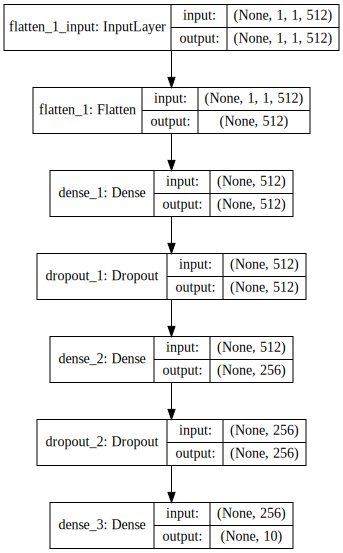

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(clf_model, show_shapes=True, 
                 show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

## Compile the model

In [13]:
clf_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

## Train the classifier

In [14]:
clf_model.fit(bottleneck_features_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/50
50000/50000 [==============================] - 8s - loss: 7.2495 - acc: 0.2799     
Epoch 2/50
50000/50000 [==============================] - 7s - loss: 2.2513 - acc: 0.2768     
Epoch 3/50
50000/50000 [==============================] - 7s - loss: 1.9096 - acc: 0.3521     
Epoch 4/50
50000/50000 [==============================] - 7s - loss: 1.7601 - acc: 0.4020     
Epoch 5/50
50000/50000 [==============================] - 7s - loss: 1.6501 - acc: 0.4355     
Epoch 6/50
50000/50000 [==============================] - 8s - loss: 1.5804 - acc: 0.4581     
Epoch 7/50
50000/50000 [==============================] - 7s - loss: 1.5295 - acc: 0.4766     
Epoch 8/50
50000/50000 [==============================] - 7s - loss: 1.4790 - acc: 0.4953     
Epoch 9/50
50000/50000 [==============================] - 7s - loss: 1.4420 - acc: 0.5078     
Epoch 10/50
50000/50000 [==============================] - 7s - loss: 1.4102 - acc: 0.5183     
Epoch 11/50
50000/50000 [========================

## Predict and test model performance

In [15]:
score = clf_model.evaluate(bottleneck_features_test, y_test, verbose=1)

 9600/10000 [===========================>..] - ETA: 0s

In [16]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.20768193054
Test accuracy: 0.6352


### Assign label to a test image

In [53]:
def predict_label(img_idx,show_proba=True):
    plt.imshow(x_test[img_idx],aspect='auto')
    plt.title("Image to be Labeled")
    plt.show()
    
    print("Actual Class:{}".format(np.nonzero(y_test[img_idx])[0][0]))
    
    test_image =np.expand_dims(x_test[img_idx], axis=0)
    bf = vgg_model.predict(test_image,verbose=0)
    pred_label = clf_model.predict_classes(bf,batch_size=1,verbose=0)
    
    print("Predicted Class:{}".format(pred_label[0]))
    if show_proba:
        print("Predicted Probabilities")
        print(clf_model.predict_proba(bf))

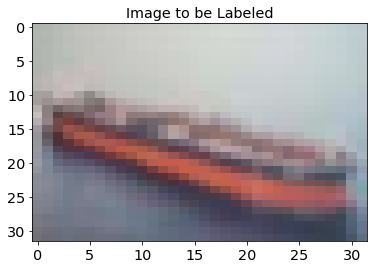

Actual Class:8
Predicted Class:8
Predicted Probabilities
1/1 [==============================] - 0s
[[  1.48474507e-03   3.18384357e-03   2.22270580e-09   1.51026228e-07
    3.13638199e-10   5.12283584e-11   8.54018176e-11   5.50038418e-11
    9.84005570e-01   1.13256825e-02]]


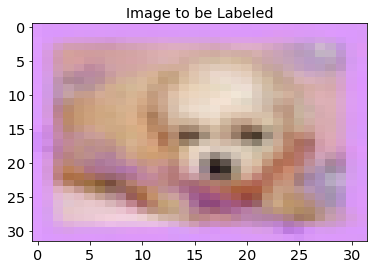

Actual Class:5
Predicted Class:5
Predicted Probabilities
1/1 [==============================] - 0s
[[  3.66592516e-08   3.57114695e-05   7.51468833e-05   1.46524936e-01
    9.77872929e-08   8.52767646e-01   5.81625965e-04   1.08531840e-05
    2.67574318e-08   3.92325774e-06]]


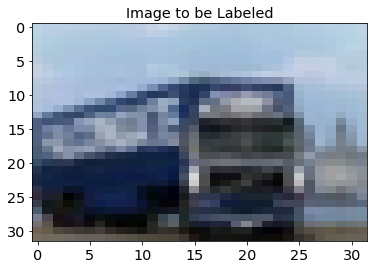

Actual Class:9
Predicted Class:9
Predicted Probabilities
1/1 [==============================] - 0s
[[  1.07423693e-01   1.45525947e-01   9.38104291e-04   4.14230488e-03
    3.73754185e-03   3.26172536e-04   4.70715531e-05   6.63721003e-03
    1.52519494e-01   5.78702450e-01]]


In [54]:
img_idx = 3999 # sample indices : 999,1999 and 3999
for img_idx in [999,1999,3999]:
    predict_label(img_idx)